# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [6]:
## your code
data_males = data.loc[data['Sex'] == 'male']
data_females = data.loc[data['Sex'] == 'female']
print(f'Count of female {data_females.shape[0]}')
print(f'Count of male {data_males.shape[0]}')

# Для определения наличия связи, учитывая большой объем выборки 
# используем Кси-квадрат

from scipy.stats import chi2_contingency
g, p, dof, expctd = chi2_contingency([
    [data_males.loc[data_males['Survived'] == 0].shape[0],
     data_males.loc[data_males['Survived'] == 1].shape[0]],
    [data_females.loc[data_females['Survived'] == 0].shape[0],
     data_females.loc[data_females['Survived'] == 1].shape[0]]
])

print(p)


Count of female 314
Count of male 577
1.1973570627755645e-58


Поскольку p < 0.05 мы можем говорить, что пол значительно влиял на выживание. Т.е. женщины выживали чаще:)

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

,Survive,Mean,Median
0,Yes,28.343690,28.0
1,No,30.626179,28.0


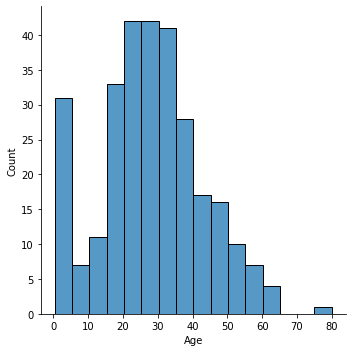

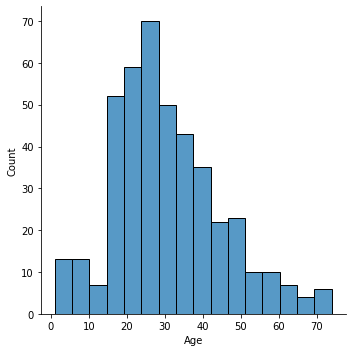

In [7]:
## your code
data_survived = data.loc[data['Survived'] == 1]
data_died = data.loc[data['Survived'] == 0]

res_df = pd.DataFrame(columns=['Survive', 'Mean', 'Median'])
res_df.loc[res_df.shape[0]] = ['Yes',
                               data_survived['Age'].mean(),
                               data_survived['Age'].median()]
res_df.loc[res_df.shape[0]] = ['No', 
                               data_died['Age'].mean(),
                               data_died['Age'].median()]


sns.displot(data_survived['Age'])
sns.displot(data_died['Age'])

res_df

Несмотря на то, что мы видим +- одинаковые медианы(медианный возраст 28 лет в двух группах). И относительно одинаковый средний возраст пассажиров. Однако, на графиках распределения у выживших имеется 2 вершины (биноминальное распределение), то можно сделапть вывод что детей с Титаника спасали.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

1 class
62.96296296296296
2 class
47.28260869565217
3 class
24.236252545824847
As we can see => % of survived is bigger in 1 class
C
55.35714285714286
Q
38.961038961038966
S
33.69565217391305
As we can see => % of survived is bigger in C embarked pass.
4.549251711298793e-23 Поскольку p < 0.05, считаем различия достоверными
1.769922284120912e-06 Поскольку p < 0.05, считаем различия достоверными


<AxesSubplot:xlabel='Pclass', ylabel='Count'>

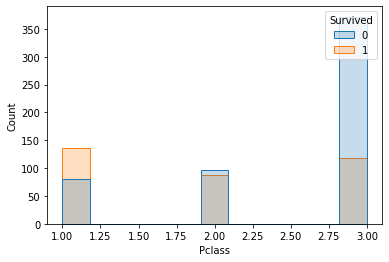

In [8]:
## your code
## Embarked: C, Q, S
## Pclass: 1, 2, 3

def get_percent_of_surv(data_fraim, name):
    print(name)
    return (data_fraim.loc[data_fraim['Survived'] == 1].shape[0] / data_fraim.shape[0]) * 100

# Начнём с класса пассажира
data_pclass_1 = data.loc[data['Pclass'] == 1]
data_pclass_2 = data.loc[data['Pclass'] == 2]
data_pclass_3 = data.loc[data['Pclass'] == 3]

print(get_percent_of_surv(data_pclass_1, '1 class'))
print(get_percent_of_surv(data_pclass_2, '2 class'))
print(get_percent_of_surv(data_pclass_3, '3 class'))
print('As we can see => % of survived is bigger in 1 class')

# Влияние места загрузки
data_embarked_C = data.loc[data['Embarked'] == 'C']
data_embarked_Q = data.loc[data['Embarked'] == 'Q']
data_embarked_S = data.loc[data['Embarked'] == 'S']

print(get_percent_of_surv(data_embarked_C, 'C'))
print(get_percent_of_surv(data_embarked_Q, 'Q'))
print(get_percent_of_surv(data_embarked_S, 'S'))
print('As we can see => % of survived is bigger in C embarked pass.')

# Поскольку данные явно различаются в относительном соотношении, можно предположить, что различия есть
# однако, при незначительном количестве пассажиров в первой группе и таком соотношении данные могут быть ложными
# достоверность различий определим с использованием Кси-квадрата

g, p, dof, expctd = chi2_contingency([
    [data_pclass_1.loc[data_pclass_1['Survived'] == 0].shape[0],
     data_pclass_2.loc[data_pclass_2['Survived'] == 0].shape[0],
     data_pclass_3.loc[data_pclass_3['Survived'] == 0].shape[0]],
    [data_pclass_1.loc[data_pclass_1['Survived'] == 1].shape[0],
     data_pclass_2.loc[data_pclass_2['Survived'] == 1].shape[0],
     data_pclass_3.loc[data_pclass_3['Survived'] == 1].shape[0]]
])

print(p, 'Поскольку p < 0.05, считаем различия достоверными')

g, p, dof, expctd = chi2_contingency([
    [data_embarked_C.loc[data_embarked_C['Survived'] == 0].shape[0],
     data_embarked_Q.loc[data_embarked_Q['Survived'] == 0].shape[0],
     data_embarked_S.loc[data_embarked_S['Survived'] == 0].shape[0]],
    [data_embarked_C.loc[data_embarked_C['Survived'] == 1].shape[0],
     data_embarked_Q.loc[data_embarked_Q['Survived'] == 1].shape[0],
     data_embarked_S.loc[data_embarked_S['Survived'] == 1].shape[0]]
])

print(p, 'Поскольку p < 0.05, считаем различия достоверными')

sns.histplot(data=data, x="Pclass", hue="Survived", element="step", common_norm=True)

Как мы видим, на выживание влиял как класс пассажира, так и место его посадки

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [9]:
data.isnull().mean() * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Хоть и влияние параметров возраста не так очевидно, однако, мы видели, что распределение признако возраста не нормальное, т.е. заполнение ячеек медианным значением может дать ложные результаты. Таким образом иммет смысл дропнуть эти строки. В номерах кают имеется большое количество брака, просто дропнем эту фичу. Учитывая низкий % пустых данных в месте посадки, и поскольку это качественный признак, то имеет смысл разделить его на 3 отдельных столбца и в нескольких из строчек будет значение признака = 0, по всем трём категориям

**(2.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [10]:
# удалим строки с пропущенным возрастом
data = data.loc[data['Age'].notnull()]
y = data['Survived'].reset_index()['Survived']

In [11]:
# Переведём порядковые и качественные признаки в отдельные столбцы. Оставшиеся фичи ('Age', 'SibSp', 'Parch', 'Fare')
X = data[['Pclass', 'Sex', 'Embarked']]

encoder = OneHotEncoder()
ohe_encoded_X = encoder.fit_transform(X).toarray()
qual_features = pd.DataFrame(ohe_encoded_X, columns=encoder.get_feature_names()).drop(columns=['x2_nan'])

good_numerical_features = data.reset_index()[['Age', 'SibSp', 'Parch', 'Fare']]

good_features_at_all = pd.concat([qual_features, good_numerical_features], axis=1).reindex(qual_features.index)
good_features_at_all.head()

,x0_1,x0_2,x0_3,x1_female,x1_male,x2_C,x2_Q,x2_S,Age,SibSp,Parch,Fare
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,22.0,1,0,7.2500
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,38.0,1,0,71.2833
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,26.0,0,0,7.9250
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,1,0,53.1000
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,35.0,0,0,8.0500


In [12]:
# KNN and Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

logistic_model = LogisticRegression(solver='newton-cg')
logistic_model.fit(X=good_features_at_all, y=y)

print('Result on logistic regression: {:f}'.format(cross_val_score(logistic_model, good_features_at_all, y, 
                      scoring='accuracy', cv=6).mean()))

KNN_model = KNeighborsRegressor(n_neighbors=3)
KNN_model.fit(good_features_at_all, y)

print('Result on KNN regression:', KNN_model.score(good_features_at_all, y))

clf = RandomForestClassifier(n_estimators=100)
clf.fit(good_features_at_all, y)
y_pred_random_forest = clf.predict(good_features_at_all)
acc_random_forest = round(clf.score(good_features_at_all, y), 2)
print ('Result on RandomForest regression:', acc_random_forest)

Result on logistic regression: 0.792717
Result on KNN regression: 0.5354586857514638
Result on RandomForest regression: 0.99


**(1.5 points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression.

In [13]:
## your code
# output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
# output.to_csv('my_submission.csv', index=False)
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
X = test_data[['Pclass', 'Sex', 'Embarked']]

encoder = OneHotEncoder()
ohe_encoded_X = encoder.fit_transform(X).toarray()
qual_features_test = pd.DataFrame(ohe_encoded_X, columns=encoder.get_feature_names())

good_numerical_features_test = test_data.reset_index()[['Age', 'SibSp', 'Parch', 'Fare']].fillna(value=0)

good_features_at_all_test = pd.concat([qual_features_test, good_numerical_features_test], axis=1).reindex(qual_features_test.index)

result = logistic_model.predict(good_features_at_all_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': result})
output.to_csv('my_submission.csv', index=False)

# simple logistic show 0.75598 score with l2
# simple logistic show 0.75358 score without l2

#kaggle nickname: https://www.kaggle.com/viktartsikhmanovich

Load the test set and make the predictions. Submit them to kaggle and see the results :)

In [14]:
KNN_result = [int(i) for i in KNN_model.predict(good_features_at_all_test)]
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': KNN_result})
output.to_csv('my_submission.csv', index=False)

#simple KNN 1 show 0.52392 score
#simple KNN 2 show 0.60047 score
#simple KNN 3 show 0.59808 score

In [15]:
random_forest_result = clf.predict(good_features_at_all_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': random_forest_result})
output.to_csv('my_submission.csv', index=False)

# random forest show 0.67703 score

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [16]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [17]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [18]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [19]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [22]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

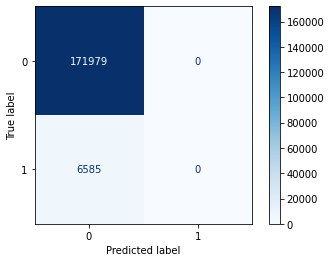

In [23]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [24]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

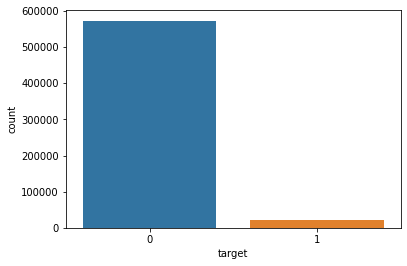

In [25]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [26]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

First on the CAP you get Gini by the usual formula:

Then on the ROC you see the perfect model and apply the same formual. We use that the area between the perfect model and the diagonal is 1/2 in this case:
Gini = 2A
AUC = A + 1/2
A = Gini / 2
=> 
Gini = 2 x AUC - 1

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

ROC analizes. 

Let's calculate the Normalized Gini Coefficient:

In [27]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [28]:
gini_normalized(y_valid, y_pred)

<ipython-input-26-7fd68ac4b908>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)


0.2558723581569817

**(1.5 points + X bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
X bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [29]:
## your code